<a href="https://colab.research.google.com/github/IldarAltynbaev/MLSnippetSimpleNeuroNwtwork/blob/TestingColab/StepikRanForContest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
from google.colab import drive
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
#Функции для рассчета агрегаты нужных полей
def count_correct(series):
    return (series == 'correct').sum()
def count_wrong(series):
    return (series == 'wrong').sum()
def count_viewed(series):
    return (series == 'viewed').sum()
def count_passed(series):
    return (series == 'passed').sum()
def count_discovered(series):
    return (series == 'discovered').sum()
def count_started_attempt(series):
    return (series == 'started_attempt').sum()


In [57]:
# Грузим датасет событий
events_dataFrame = pd.read_csv('/content/drive/MyDrive/DS data/event_data_train.csv')
events_dataFrame['date_time'] = pd.to_datetime(events_dataFrame['timestamp'],unit='s')
events_dataFrame.sort_values('date_time');
len(events_dataFrame.user_id.unique())

19234

In [58]:
# Вычисляем дату первой активности пользователя
aggregated_events = events_dataFrame.groupby(['user_id'])['date_time'].min().reset_index(name='first_date')

In [59]:
events_dataFrame = pd.merge(events_dataFrame, aggregated_events, on='user_id',how='left')

In [60]:
# Получаем данные для определения y_train/y_test класса
submission_df = pd.read_csv('/content/drive/MyDrive/DS data/submissions_data_train.csv')
submission_df_first2Days = submission_df.copy()
submission_df = submission_df.drop(['timestamp'],axis=1)
submission_df.drop_duplicates()
submission_df_first2Days
#submission_df['date_time'] = pd.to_datetime(events_dataFrame['timestamp'],unit='s')
#submission_df.sort_values('date_time')

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853
...,...,...,...,...
509099,120745,1501946959,wrong,2615
509100,120745,1503059927,correct,13177
509101,120745,1506348153,wrong,15253
509102,120745,1523035316,wrong,1424


In [61]:
submission_count_correct = submission_df.groupby(["user_id"])['submission_status'].apply(count_correct).reset_index(name='count_correct')

In [62]:
events_dataFrame_with_correct = pd.merge(events_dataFrame, submission_count_correct, on='user_id',how='left')
events_dataFrame_with_correct = events_dataFrame_with_correct.fillna(0)
events_dataFrame_with_correct = events_dataFrame_with_correct[events_dataFrame_with_correct.date_time <= events_dataFrame_with_correct.first_date + timedelta(days=2)]
events_dataFrame_with_correct['course_passed'] = events_dataFrame_with_correct['count_correct'] > 40
events_dataFrame_with_correct = events_dataFrame_with_correct.drop('count_correct', axis=1)
events_dataFrame_with_correct

,step_id,timestamp,action,user_id,date_time,first_date,course_passed
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15 04:00:48,False
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15 04:00:48,False
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15 04:00:48,False
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15 04:00:48,False
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15 04:00:48,False
...,...,...,...,...,...,...,...
3480530,32953,1526766998,viewed,24555,2018-05-19 21:56:38,2018-05-19 11:37:47,False
3480531,32953,1526766998,discovered,24555,2018-05-19 21:56:38,2018-05-19 11:37:47,False
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19 23:32:30,False
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19 23:32:30,False


In [63]:
# Теперь посчитаем активность сабмитов за первые 2 дня активности пользователя, для этого сабмит дата сет придется переинициализи
submission_df_first2Days['date_time'] = pd.to_datetime(submission_df_first2Days['timestamp'],unit='s')
aggregated_submissions = submission_df_first2Days.groupby(['user_id'])['date_time'].min().reset_index(name='first_date')

submission_df_first2Days = pd.merge(submission_df_first2Days, aggregated_submissions, on='user_id',how='left')
submission_df_first2Days = submission_df_first2Days[submission_df_first2Days.date_time <= submission_df_first2Days.first_date + timedelta(days=2)]
submission_df_first2Days = submission_df_first2Days.drop(['date_time', 'first_date'], axis=1)
submission_df_first2Days = submission_df_first2Days.drop_duplicates()

In [64]:
submission_df_count_wrong_first2Days = submission_df_first2Days.groupby(["user_id"])['submission_status'].apply(count_wrong).reset_index(name='count_wrong')
submission_df_count_correct_first2Days = submission_df_first2Days.groupby(["user_id"])['submission_status'].apply(count_correct).reset_index(name='count_correct')

In [65]:
events_dataFrame_with_correct = pd.merge(events_dataFrame_with_correct, submission_df_count_wrong_first2Days, on='user_id',how='left')
events_dataFrame_with_correct = pd.merge(events_dataFrame_with_correct, submission_df_count_correct_first2Days, on='user_id',how='left')
events_dataFrame_with_correct = events_dataFrame_with_correct.fillna(0)


In [66]:
action_viewed = events_dataFrame_with_correct.groupby(["user_id"])['action'].apply(count_viewed).reset_index(name='count_viewed')
action_passed = events_dataFrame_with_correct.groupby(["user_id"])['action'].apply(count_passed).reset_index(name='count_passed')
action_discovered = events_dataFrame_with_correct.groupby(["user_id"])['action'].apply(count_discovered).reset_index(name='count_discovered')
action_started_attempt = events_dataFrame_with_correct.groupby(["user_id"])['action'].apply(count_started_attempt).reset_index(name='count_started_attempt')

events_dataFrame_with_correct = pd.merge(events_dataFrame_with_correct, action_viewed, how='left', on='user_id')
events_dataFrame_with_correct = pd.merge(events_dataFrame_with_correct, action_passed, how='left', on='user_id')
events_dataFrame_with_correct = pd.merge(events_dataFrame_with_correct, action_discovered, how='left', on='user_id')
events_dataFrame_with_correct = pd.merge(events_dataFrame_with_correct, action_started_attempt, how='left', on='user_id')

In [67]:
events_dataFrame_with_correct = events_dataFrame_with_correct.drop(['timestamp','action','date_time', 'first_date'],axis=1)

In [68]:
events_dataFrame_with_correct = events_dataFrame_with_correct.fillna(0)
events_dataFrame_with_correct = events_dataFrame_with_correct.drop_duplicates()

In [69]:
set_x = events_dataFrame_with_correct.drop(['course_passed'],axis=1)
set_y = events_dataFrame_with_correct[['course_passed', 'user_id']]
set_x = set_x.set_index('user_id')
set_y = set_y.set_index('user_id')

In [70]:
X_train, X_test, y_train, y_test = train_test_split(set_x, set_y, train_size = 0.66, random_state=42)

In [71]:
clf = RandomForestClassifier(criterion='entropy',n_jobs=-1, max_depth= 13, min_samples_split = 40)
#param_grid = {'max_depth':range(1,20,5), 'min_samples_split': range(1,50,5),'min_samples_leaf': range(1,50,5), 'n_estimators':range(1,200,10)}
param_grid = {'n_estimators':range(1,100,10)}

In [72]:
grid = GridSearchCV(clf,param_grid,cv=5)

In [ ]:
grid.fit(X_train, y_train.values.ravel())

In [74]:
best_cls = grid.best_estimator_
y_pred = grid.predict(X_train)
grid.best_params_

{'n_estimators': 51}

In [75]:
metrics.roc_auc_score(y_train, y_pred)

0.7740046337654105

In [76]:
#fig = plt.figure(figsize=(25,20))
#fig = tree.plot_tree(best_cls, feature_names=X_train.columns,class_names=['not_passed', 'passed'], filled=True)


In [77]:
#y_pred = best_cls.predict_proba(X_test)
y_pred = best_cls.predict(X_test)

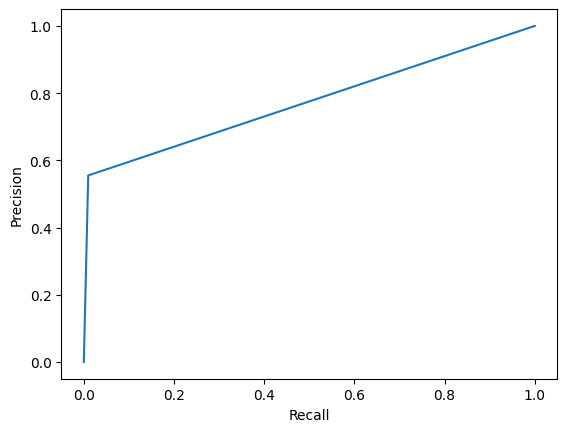

In [78]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
plt.plot(fpr,tpr)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()


In [79]:
metrics.roc_auc_score(y_test, y_pred)

0.7726213306149601